# DREAM - Example on Patent data

In [1]:
!nvidia-smi

Tue Apr  9 14:17:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import pandas as pd
import numpy as np

import torch

from data_generation.rem_generation import *

from model.dream import DREAM
from model.dream_gp import DREAM_gp


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

sns.set(rc={'figure.figsize':(11.7,8.27)})

import warnings
warnings.filterwarnings('ignore')

For this example, we will use a reduced version of the Patent citation data set, which consists of 8.3 million patents and 100 million citations. 

In [6]:
data = pd.read_csv('data/patent_sample_10k.csv')
data

,sender,receiver,receiver_2,event_day,rec_pub_day,rec_pub_year,rec_pub_day_2,rec_pub_year_2,lag,lag_2,jac_sim,jac_sim_2,cumu_cit_rec,cumu_cit_rec_2,rec_outd,rec_outd_2,tfe,tfe_2,sim,sim_2
0,4153419,4033729,4017882,1223,551,1977,467,1977,672,756,1.000000,0.0,2,2.0,1,1,70,273.0,0.580668,0.036364
1,4210924,3990090,4028149,1643,306,1976,523,1977,1337,1120,1.000000,1.0,1,2.0,1,1,1337,189.0,0.902281,0.429942
2,4252494,4158541,3995416,1881,1265,1979,341,1976,616,1540,0.000000,0.0,1,4.0,1,1,616,623.0,0.356069,0.318963
3,4255240,4176215,3977610,1895,1426,1979,243,1976,469,1652,0.500000,0.0,1,4.0,1,1,469,280.0,1.000000,0.297673
4,4266697,4121584,4146082,1958,1027,1978,1181,1979,931,777,1.000000,0.0,14,1.0,1,2,14,777.0,0.647222,0.365250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,11534329,5928249,10905415,17162,8608,1999,16469,2021,8554,693,1.000000,1.0,21,5.0,9,21,231,7.0,0.468264,0.284689
9996,11536479,9285802,6787790,17162,14684,2016,10477,2004,2478,6685,0.333333,0.0,45,5.0,1147,1,287,4165.0,0.641763,0.257017
9997,11538706,9463543,6921933,17162,14894,2016,10799,2005,2268,6363,0.666667,0.5,4,5.0,1,15,385,2982.0,0.395067,0.312574
9998,11534313,5452407,4732818,17162,7201,1995,4464,1988,9961,12698,0.500000,0.0,366,2.0,20,17,91,602.0,0.424185,0.011320


In [7]:
data['rec_outd'] = np.log(data['rec_outd'])
data['rec_outd_2'] = np.log(data['rec_outd_2'])

data['cumu_cit_rec'] = np.log(data['cumu_cit_rec'])
data['cumu_cit_rec_2'] = np.log(data['cumu_cit_rec_2'])

data['tfe'] = np.log(data['tfe']+1)
data['tfe_2'] = np.log(data['tfe_2']+1)

In [8]:
events = ['rec_pub_year','sim','lag','jac_sim','cumu_cit_rec','rec_outd','tfe']
non_events = ['rec_pub_year_2','sim_2','lag_2','jac_sim_2','cumu_cit_rec_2','rec_outd_2','tfe_2']

In [16]:
x_event = torch.tensor(data[events].values).type(torch.float32)
x_non_event = torch.tensor(data[non_events].values).type(torch.float32)

In [17]:
x_event

tensor([[1.9770e+03, 5.8067e-01, 6.7200e+02,  ..., 6.9315e-01, 0.0000e+00,
         4.2627e+00],
        [1.9760e+03, 9.0228e-01, 1.3370e+03,  ..., 0.0000e+00, 0.0000e+00,
         7.1989e+00],
        [1.9790e+03, 3.5607e-01, 6.1600e+02,  ..., 0.0000e+00, 0.0000e+00,
         6.4249e+00],
        ...,
        [2.0160e+03, 3.9507e-01, 2.2680e+03,  ..., 1.3863e+00, 0.0000e+00,
         5.9558e+00],
        [1.9950e+03, 4.2418e-01, 9.9610e+03,  ..., 5.9026e+00, 2.9957e+00,
         4.5218e+00],
        [2.0020e+03, 5.8278e-01, 7.4620e+03,  ..., 3.8918e+00, 1.0986e+00,
         0.0000e+00]])

In [18]:
stat_test_original = torch.zeros(101,7)

#stat_test_original[:,0] = torch.linspace(events[:,0].min().item(),events[:,0].max().item(),101)
for i in range(7):
    stat_test_original[:,i] = torch.linspace(x_event[:,i].min().item(),x_event[:,i].max().item(),101)


In [19]:
ev_std = torch.std(x_event,dim=0)
ev_mean = torch.mean(x_event,dim=0)

x_event = ((x_event-ev_mean)/ev_std)
x_non_event = ((x_non_event-ev_mean)/ev_std)

stat_test = (stat_test_original-ev_mean)/ev_std

In [20]:
repetitions = 5
models = tuple(DREAM(7,[512]*7,[1024,512,256,128],dropout=0.1,feature_dropout=0.0) for _ in range(repetitions))

In [21]:
DREAM_gp_5 = DREAM_gp(models=models)
DREAM_gp_5.train_repetitions(x_event=x_event,
                        x_non_event=x_non_event,
                        stat_test=stat_test,
                        repetitions=repetitions,
                        batch_size=2**10,
                        model_verbose=False,
                        gradient_clipping=1.0)

100%|██████████| 5/5 [00:10<00:00,  2.06s/it]


After having trained the different models, we will use the Gaussian process approach to estimate the effects of the first two statistics (publication year and textual similarity). 

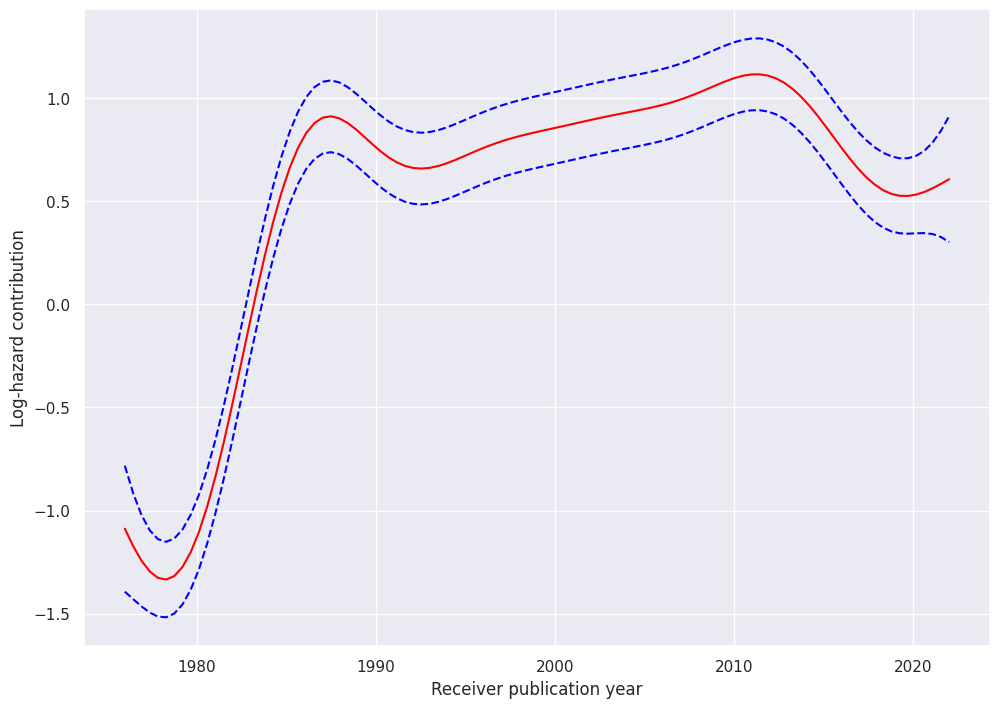

In [26]:
m,s = DREAM_gp_5.gp_feature(0)

sns.lineplot(x=stat_test_original[:,0],y=m,color='red')
sns.lineplot(x=stat_test_original[:,0],y=m+2*s,color='blue',linestyle='--')
sns.lineplot(x=stat_test_original[:,0],y=m-2*s,color='blue',linestyle='--')
plt.xlabel('Receiver publication year')
plt.ylabel('Log-hazard contribution')
plt.show()

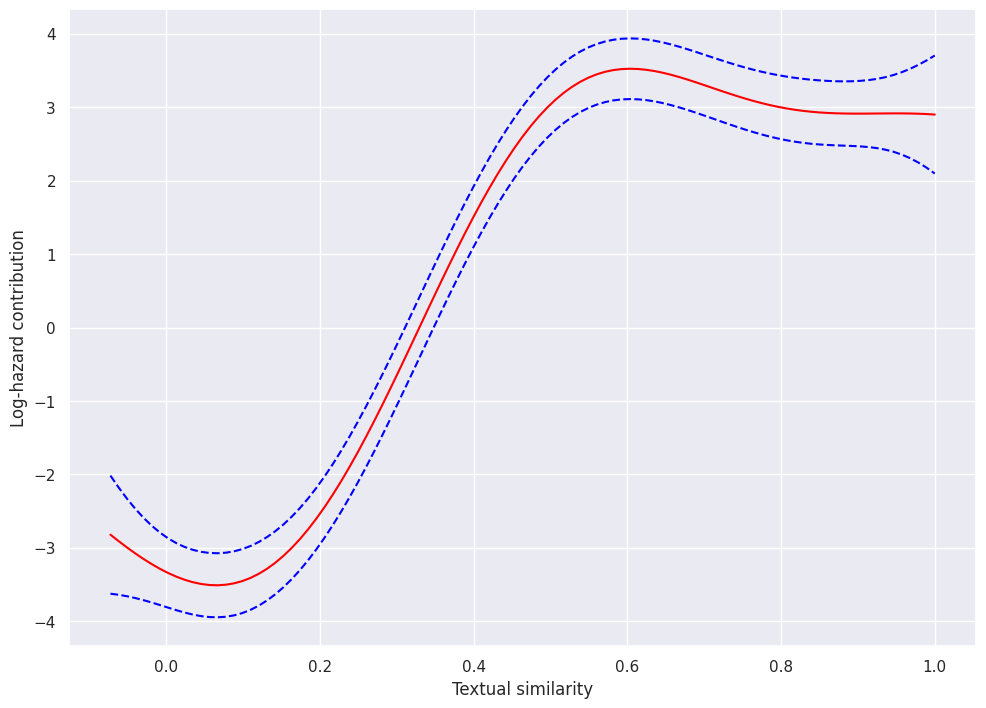

In [27]:
m,s = DREAM_gp_5.gp_feature(1)

sns.lineplot(x=stat_test_original[:,1],y=m,color='red')
sns.lineplot(x=stat_test_original[:,1],y=m+2*s,color='blue',linestyle='--')
sns.lineplot(x=stat_test_original[:,1],y=m-2*s,color='blue',linestyle='--')
plt.xlabel('Textual similarity')
plt.ylabel('Log-hazard contribution')
plt.show()